# 03 - Preprocesssing & Modelling

## 3.1 Contents:<a id='2.1_Contents'></a>
* [3.2_Objective:](#2.2_Objective:)
* [3.3_Imports:](#2.3_Imports:)
* [3.4_Preprocessing:](#2.4_Preprocessing_Data:)

# 3.2 Objective:

# 3.3 Imports:

In [6]:
# Importing libraries
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
# Above is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline

# For time stamps
from datetime import datetime

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

2024-07-20 17:06:03.516322: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Define Key Variables:

In [8]:
train_split_percentage = 0.95
seq_length = 30 # for LSTM model

## 3.3.1 Load Data:

In [10]:
df_load = pd.read_csv('../data/processed/df_cleaned.csv')

In [11]:
# Set the 'Date' column back to the index
# Convert 'Date' column to datetime
df_load['Date'] = pd.to_datetime(df_load['Date'])
df_load.set_index('Date', inplace=True)
df_load.head(10)

,ticker_symbol,company_name,Open,High,Low,Close,Adj Close,Volume,Daily_Return,30_MA,90_MA,RSI,MACD,symbol,actualEarningResult,estimatedEarning
Date,,,,,,,,,,,,,,,,
2014-07-21,TSLA,TESLA,14.483333,14.880667,14.448000,14.702667,14.702667,57333000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
2014-07-22,TSLA,TESLA,14.812667,14.886667,14.607333,14.638667,14.638667,40950000,-0.004353,NaN,NaN,NaN,-0.005105,NaN,NaN,NaN
2014-07-23,TSLA,TESLA,14.667333,14.983333,14.628667,14.832667,14.832667,46249500,0.013253,NaN,NaN,NaN,0.006429,NaN,NaN,NaN
2014-07-24,TSLA,TESLA,14.883333,15.006667,14.720000,14.902667,14.902667,48682500,0.004719,NaN,NaN,NaN,0.020976,NaN,NaN,NaN
2014-07-25,TSLA,TESLA,14.848000,15.131333,14.783333,14.904667,14.904667,46306500,0.000134,NaN,NaN,NaN,0.032294,NaN,NaN,NaN
2014-07-28,TSLA,TESLA,14.950000,15.466667,14.760000,14.988000,14.988000,97714500,0.005591,NaN,NaN,NaN,0.047441,NaN,NaN,NaN
2014-07-29,TSLA,TESLA,15.107333,15.220000,14.990667,15.000667,15.000667,50736000,0.000845,NaN,NaN,NaN,0.059778,NaN,NaN,NaN
2014-07-30,TSLA,TESLA,14.794667,15.306667,14.736000,15.261333,15.261333,73917000,0.017377,NaN,NaN,NaN,0.089557,NaN,NaN,NaN
2014-07-31,TSLA,TESLA,15.284000,15.426667,14.766667,14.886667,14.886667,116236500,-0.024550,NaN,NaN,NaN,0.081979,TSLA,0.01,0.00238


In [12]:
df_load.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7551 entries, 2014-07-21 to 2024-07-19
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ticker_symbol        7551 non-null   object 
 1   company_name         7551 non-null   object 
 2   Open                 7551 non-null   float64
 3   High                 7551 non-null   float64
 4   Low                  7551 non-null   float64
 5   Close                7551 non-null   float64
 6   Adj Close            7551 non-null   float64
 7   Volume               7551 non-null   int64  
 8   Daily_Return         7548 non-null   float64
 9   30_MA                7464 non-null   float64
 10  90_MA                7284 non-null   float64
 11  RSI                  7512 non-null   float64
 12  MACD                 7551 non-null   float64
 13  symbol               119 non-null    object 
 14  actualEarningResult  7543 non-null   float64
 15  estimatedEarning    

In [13]:
# Dropping rows with null values for 90 day moving average, this should only clear the first ~90 days worth of data. 
df_load = df_load.dropna(subset=['90_MA'])
# Drop feature 'Symbol' dulplicate for ticker_symbol.
df_load = df_load.drop(columns = 'symbol')

In [14]:
df_load.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7284 entries, 2014-11-24 to 2024-07-19
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ticker_symbol        7284 non-null   object 
 1   company_name         7284 non-null   object 
 2   Open                 7284 non-null   float64
 3   High                 7284 non-null   float64
 4   Low                  7284 non-null   float64
 5   Close                7284 non-null   float64
 6   Adj Close            7284 non-null   float64
 7   Volume               7284 non-null   int64  
 8   Daily_Return         7284 non-null   float64
 9   30_MA                7284 non-null   float64
 10  90_MA                7284 non-null   float64
 11  RSI                  7284 non-null   float64
 12  MACD                 7284 non-null   float64
 13  actualEarningResult  7284 non-null   float64
 14  estimatedEarning     7284 non-null   float64
dtypes: float64(12), int6

# 3.4 Preprocessing Data:

In [16]:
# unzip df by stock and add it to a dictionary.
stock_data = {}
tech_list = df_load['ticker_symbol'].unique()
# Iterate over each unique ticker symbol in the DataFrame
for ticker in tech_list:
    # Filter the DataFrame for the current ticker symbol
    stock_df = df_load[df_load['ticker_symbol'] == ticker].copy()
    stock_df = stock_df[['ticker_symbol', 'company_name', 'Open', 'High', 'Low', 
       'Adj Close', 'Volume', 'Daily_Return', '30_MA', '90_MA', 'RSI', 'MACD',
       'actualEarningResult', 'estimatedEarning', 'Close']]
    # Store the DataFrame in the dictionary
    stock_data[ticker] = stock_df
    
# Display the DataFrame for a specific stock, e.g., 'TSLA'
stock_data['TSLA'].head()

,ticker_symbol,company_name,Open,High,Low,Adj Close,Volume,Daily_Return,30_MA,90_MA,RSI,MACD,actualEarningResult,estimatedEarning,Close
Date,,,,,,,,,,,,,,,
2014-11-24,TSLA,TESLA,16.346666,16.506666,16.042667,16.448000,71845500,0.016229,16.011022,16.586704,55.494419,0.128355,-0.03987,-0.02009,16.448000
2014-11-25,TSLA,TESLA,16.490000,16.648001,16.406000,16.539333,47397000,0.005553,16.057756,16.607111,63.312591,0.122035,-0.03987,-0.02009,16.539333
2014-11-26,TSLA,TESLA,16.556000,16.600000,16.440001,16.562668,29718000,0.001411,16.099400,16.628489,56.636040,0.117555,-0.03987,-0.02009,16.562668
2014-11-28,TSLA,TESLA,16.356667,16.445999,16.167999,16.301332,31795500,-0.015779,16.139778,16.644807,53.769630,0.091857,-0.03987,-0.02009,16.301332
2014-12-01,TSLA,TESLA,16.077333,16.164667,15.267333,15.442667,129291000,-0.052675,16.149022,16.650807,42.483559,0.002180,-0.03987,-0.02009,15.442667


## 3.4.1 Dummy regressor:

### Train/Test Split Data:

In [19]:
# fuction to split df into train and test.
def train_test_data(df):
    X = df
    y = df['Close']
     # Calculate the split index, split percentage defined up top in imports. 
    split_index = int(len(df) * train_split_percentage)
    
    # Split the data into training and test sets
    # IMPORTANT NOTE: Add a 1 row lag between X and Y. The goal is to predict next days Close Price using past data.
    X_train = X.iloc[:split_index]
    X_test = X.iloc[split_index:-1]
    y_train = y.iloc[1:split_index+1]
    y_test = y.iloc[split_index+1:]
    
    return X_train, X_test, y_train, y_test

split_data = {}
for stock in tech_list:
    split_data[stock] = train_test_data(stock_data[stock])

In [20]:
# check to see shapes of train and test df and split correctly.
for i in range(4):
    print(split_data['TSLA'][i].shape)

(2306, 15)
(121, 15)
(2306,)
(121,)


In [21]:
# Dummy regression training model function
def train_dummy(X_train, y_train):
    dumb_reg = DummyRegressor(strategy='mean')
    dumb_reg.fit(X_train, y_train)
    return dumb_reg

trained_models = {}
for stock in tech_list:
    X_train, X_test, y_train, y_test = split_data[stock]
    trained_models[stock] = train_dummy(X_train, y_train)

In [22]:
# Dummy regression evaluation model function. 
def evaluate_models(model, X_test, y_test):
    results = {}  
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    results = {'MAE': mae, 'RMSE': rmse}
    return results

evaluation_results = {}
for stock in tech_list:
    X_train, X_test, y_train, y_test = split_data[stock]
    evaluation_results[stock] = evaluate_models(trained_models[stock], X_test, y_test)

for stock, results in evaluation_results.items():
    print(f"Evaluation results for {stock}:")
    print(f"MAE = {results['MAE']}, RMSE = {results['RMSE']}")

Evaluation results for TSLA:
MAE = 83.92599192178875, RMSE = 87.52686296465784
Evaluation results for AMD:
MAE = 121.98609533969403, RMSE = 122.81887787806762
Evaluation results for NVDA:
MAE = 84.69970528071703, RMSE = 87.12997743444586


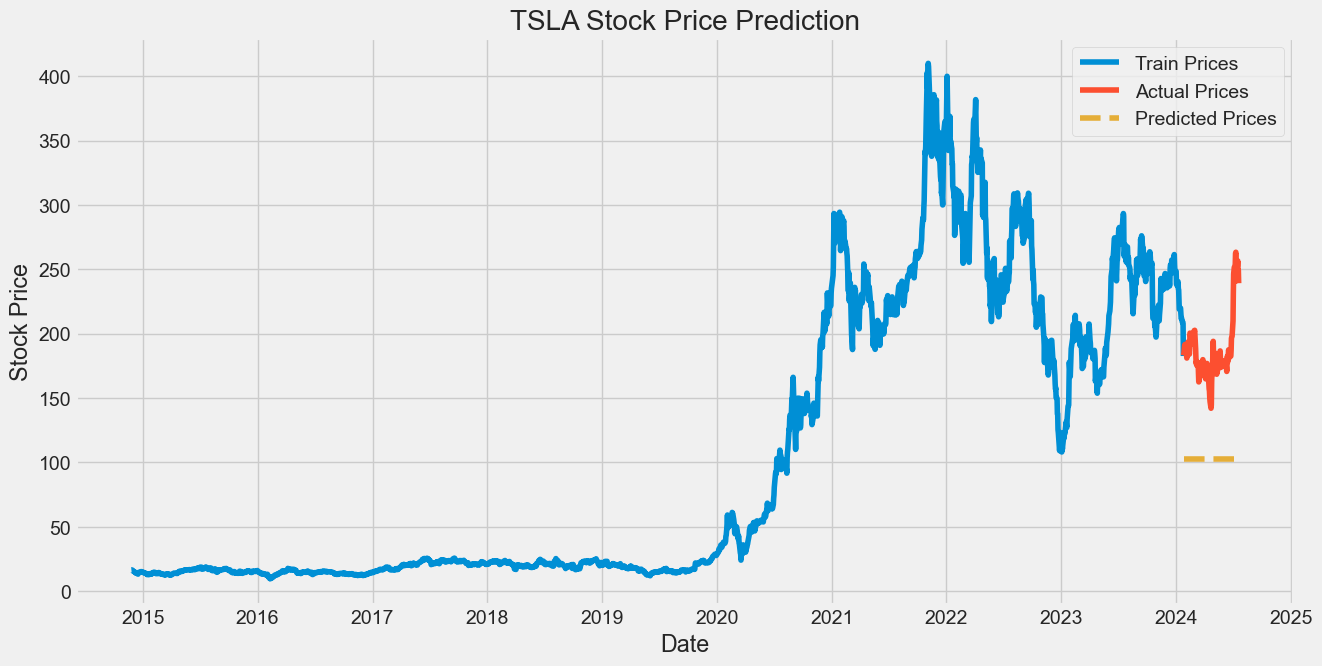

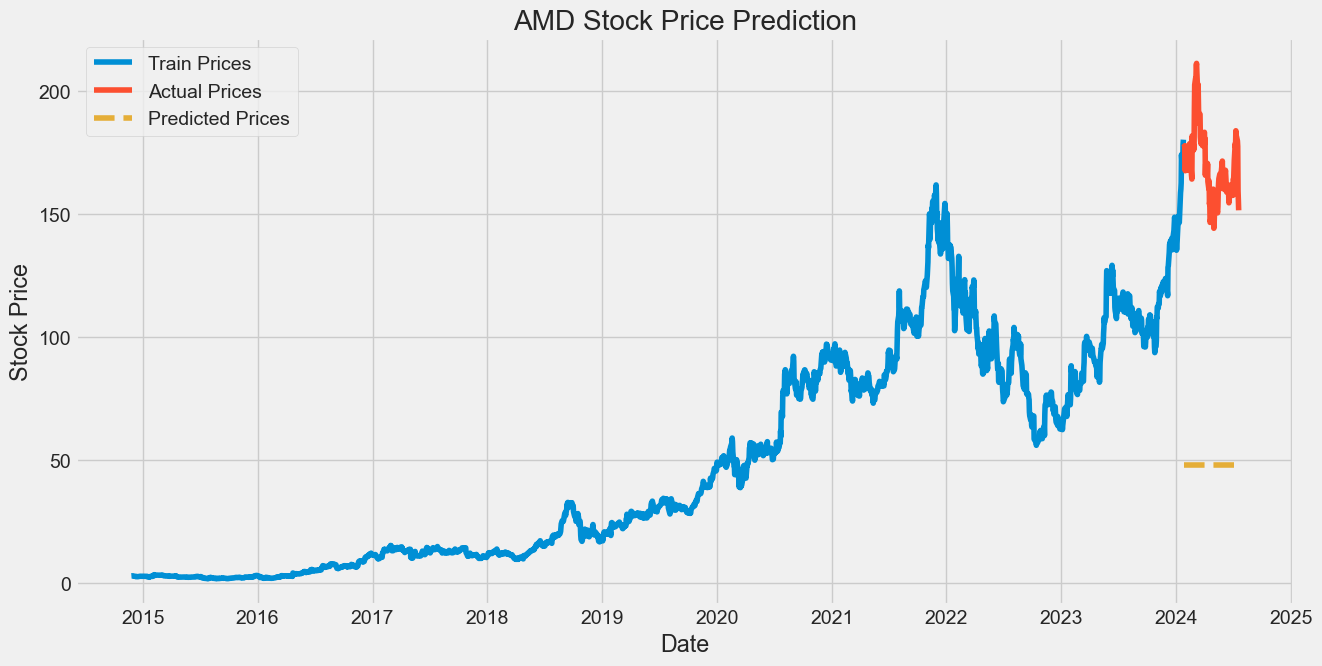

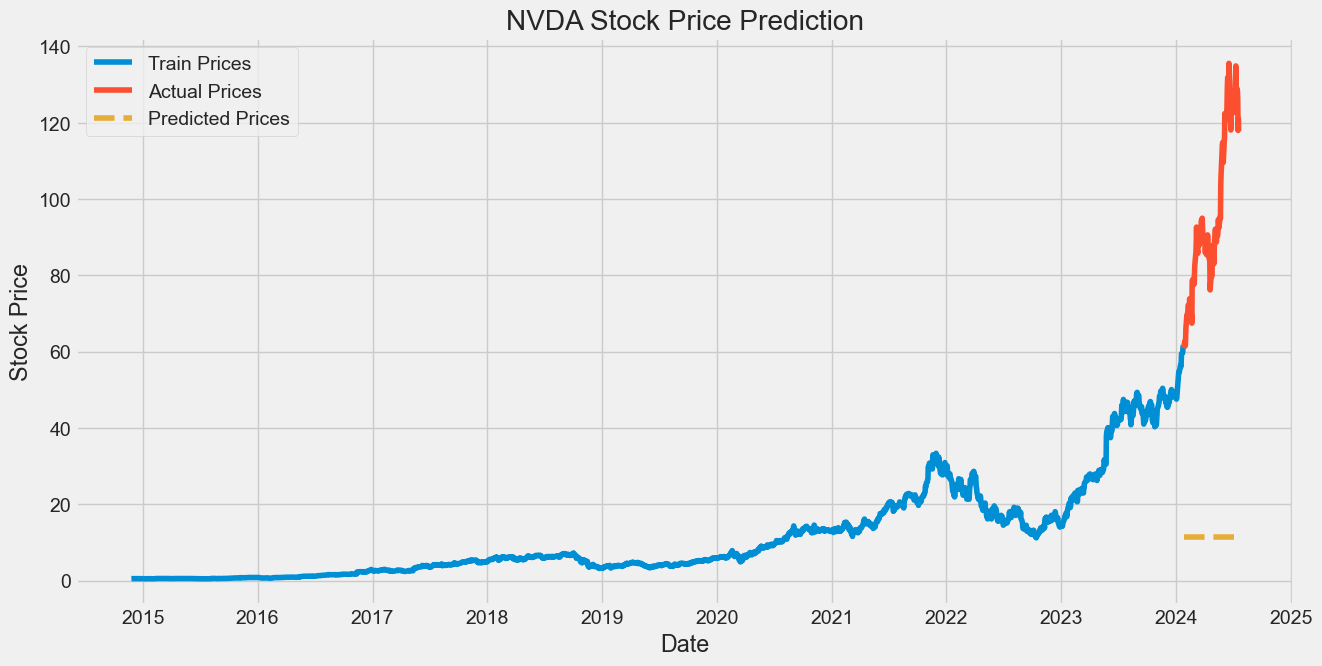

In [23]:
# Visualizing Dummy Regressor prediction.
def plot_predictions(model, y_train, X_test, y_test, stock):
    predictions = model.predict(X_test)
    plt.figure(figsize=(14, 7))
    plt.plot(y_train.index, y_train, label='Train Prices')
    plt.plot(y_test.index, y_test, label='Actual Prices')
    plt.plot(y_test.index, predictions, label='Predicted Prices', linestyle='--')
    plt.title(f"{stock} Stock Price Prediction")
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

# Plot predictions for the dummy regressor.
for stock in tech_list:
    X_train, X_test, y_train, y_test = split_data[stock]
    best_model = trained_models[stock]
    plot_predictions(best_model, y_train, X_test, y_test, stock)

# 3.5.0 Modelling:

## 3.5.1 Applying Machine Learning Models:

In [89]:
# fuction to split df into train and test.
def ml_preprocess_data(df):
    X = df.drop(columns=['company_name', 'ticker_symbol', 'Close'])
    y = df['Close']
     # Calculate the split index
    split_index = int(len(df) * train_split_percentage)
    
    # Split the data into training and test sets
    # IMPORTANT NOTE: Add a 1 row lag between X and Y. The goal is to predict next days Close Price using past data.
    X_train = X.iloc[:split_index]
    X_test = X.iloc[split_index:-1]
    y_train = y.iloc[1:split_index+1]
    y_test = y.iloc[split_index+1:]
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, y_train, y_test

ml_processed_data = {}
for stock in tech_list:
    ml_processed_data[stock] = ml_preprocess_data(stock_data[stock])

In [91]:
# check to see shapes of train and test df and split correctly.
for i in range(4):
    print(ml_processed_data['TSLA'][i].shape)
    #print(processed_data['TSLA'][i])

(2306, 12)
(121, 12)
(2306,)
(121,)


In [93]:
# Training Models function. We will explore Linear Regression, DecisionTree Regressor, and Random Forest Regressor.
def ml_train_models(X_train, y_train):
    models = {
        'Linear Regression': LinearRegression(),
        'Decision Tree': DecisionTreeRegressor(),
        'Random Forest': RandomForestRegressor(n_estimators=100)
    }
    trained_models = {}
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        trained_models[model_name] = model
    return trained_models

ml_trained_models = {}
for stock in tech_list:
    X_train, X_test, y_train, y_test = ml_processed_data[stock]
    ml_trained_models[stock] = ml_train_models(X_train, y_train)

In [95]:
def ml_evaluate_models(models, X_test, y_test):
    results = {}
    for model_name, model in models.items():
        predictions = model.predict(X_test)
        mae = mean_absolute_error(y_test, predictions)
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        results[model_name] = {'MAE': mae, 'RMSE': rmse}
    return results

ml_evaluation_results = {}
for stock in tech_list:
    X_train, X_test, y_train, y_test = ml_processed_data[stock]
    ml_evaluation_results[stock] = ml_evaluate_models(ml_trained_models[stock], X_test, y_test)

for stock, results in ml_evaluation_results.items():
    print(f"Evaluation results for {stock}:")
    for model_name, metrics in results.items():
        print(f"{model_name}: MAE = {metrics['MAE']}, RMSE = {metrics['RMSE']}")

Evaluation results for TSLA:
Linear Regression: MAE = 4.761281658580042, RMSE = 6.569041060293892
Decision Tree: MAE = 8.795233356065985, RMSE = 11.056552610346348
Random Forest: MAE = 5.117666692812578, RMSE = 7.1659821955096525
Evaluation results for AMD:
Linear Regression: MAE = 3.7955258079826337, RMSE = 5.225885299599488
Decision Tree: MAE = 9.825703392344073, RMSE = 13.465099004964687
Random Forest: MAE = 7.238814009359062, RMSE = 10.82822204466515
Evaluation results for NVDA:
Linear Regression: MAE = 2.420699357476408, RMSE = 3.2430916311819407
Decision Tree: MAE = 34.997586526161385, RMSE = 40.44316384673505
Random Forest: MAE = 35.609578680873895, RMSE = 41.023065318460425


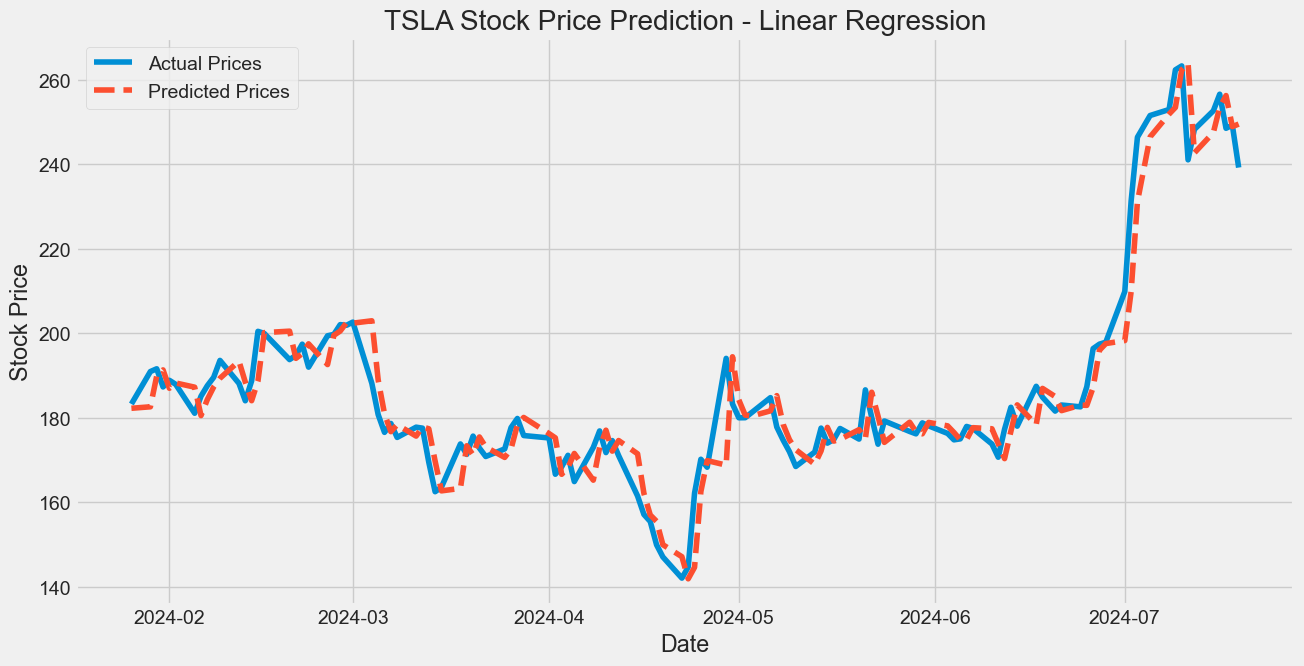

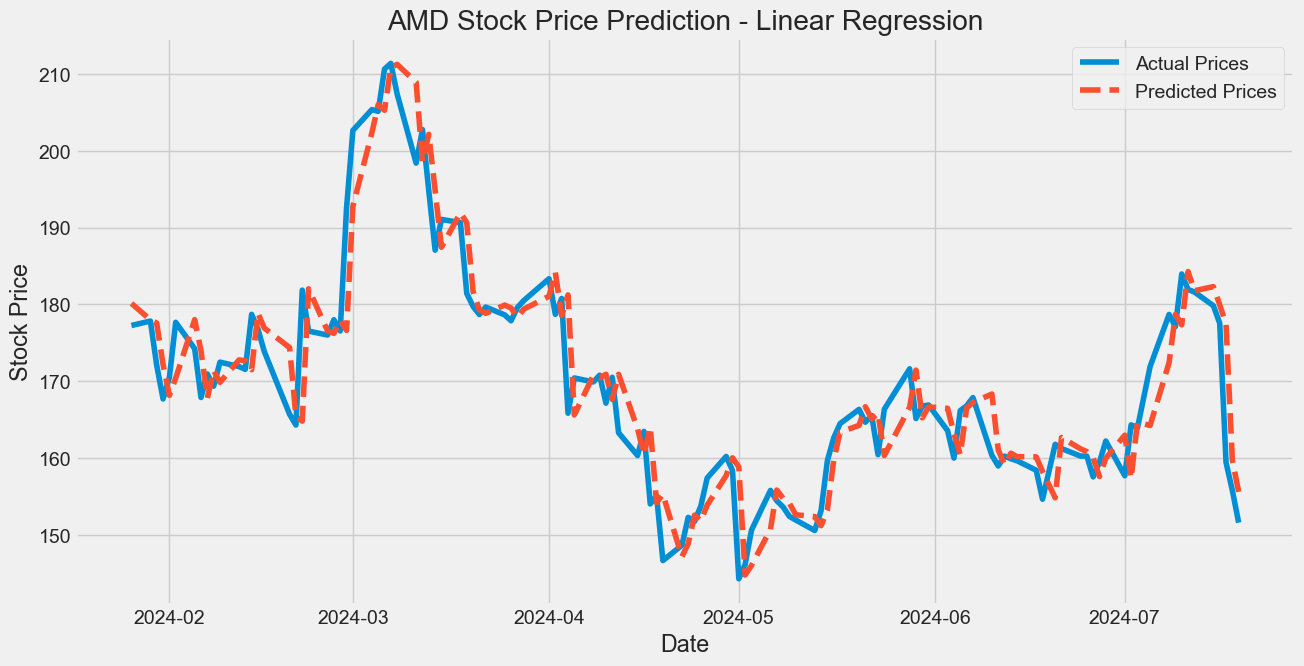

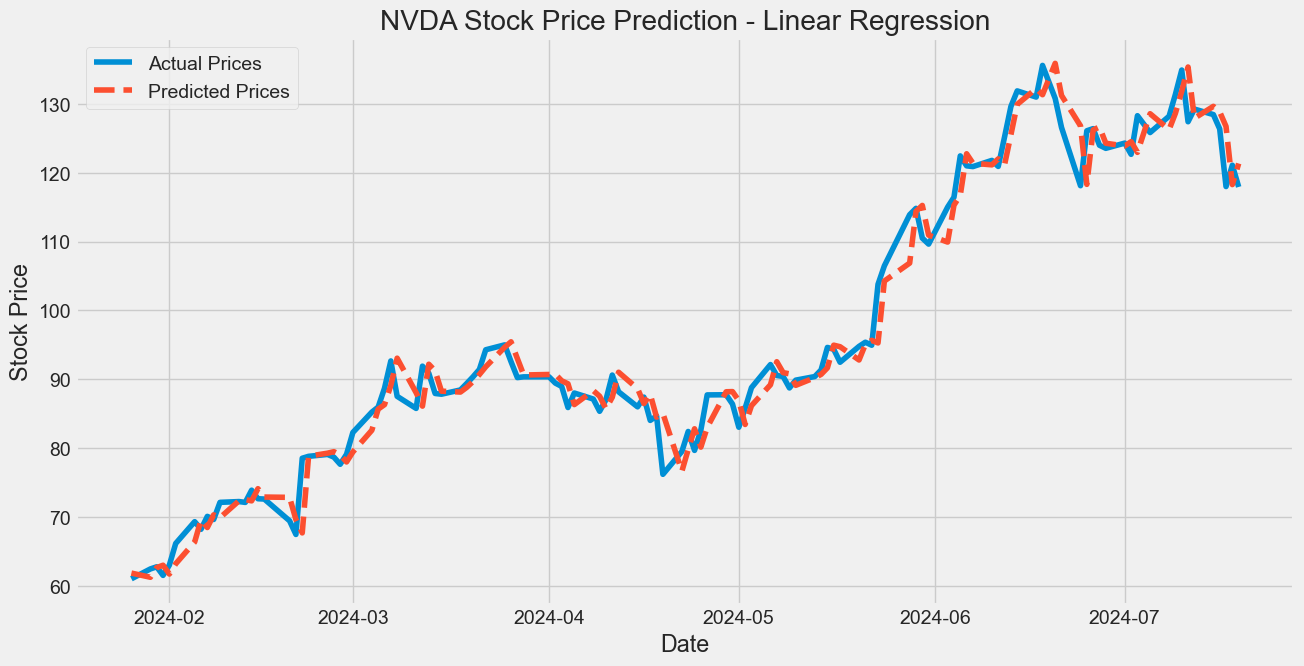

In [97]:
def ml_plot_predictions(model, y_train, X_test, y_test, stock):
    predictions = model.predict(X_test)
    #print(y_test, predictions)
    plt.figure(figsize=(14, 7))
    #plt.plot(y_train.index, y_train, label='Train Prices')
    plt.plot(y_test.index, y_test, label='Actual Prices')
    plt.plot(y_test.index, predictions, label='Predicted Prices', linestyle='--')
    plt.title(f"{stock} Stock Price Prediction - Linear Regression")
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

# Plot predictions for the best model (Random Forest in this example)
for stock in tech_list:
    X_train, X_test, y_train, y_test = ml_processed_data[stock]
    ml_best_model = ml_trained_models[stock]['Linear Regression']
    ml_plot_predictions(ml_best_model, y_train, X_test, y_test, stock)

## 3.5.2 Deep Learning Models:

In [75]:
# Scale DataFrame:
def scale_data(df):
    scale_df = df.drop(columns=['company_name', 'ticker_symbol'])
    scaler = MinMaxScaler()
    # Fit and transform the data
    scaled_data = scaler.fit_transform(scale_df)
    # Convert the scaled data back to a DataFrame
    scaled_df = pd.DataFrame(scaled_data, columns=scale_df.columns)
    # Add the date index from lstm_df to scaled_df
    scaled_df.index = df.index
    print(scaled_df.shape)
    return scaled_df, scaler

scaled_data = {}
scalers = {}  # Store the scalers for each stock
for stock in tech_list:
    scaled_data[stock], scalers[stock] = scale_data(stock_data[stock])

(2428, 13)
(2428, 13)
(2428, 13)


In [77]:
scaled_data['TSLA'].head()

,Open,High,Low,Adj Close,Volume,Daily_Return,30_MA,90_MA,RSI,MACD,actualEarningResult,estimatedEarning,Close
Date,,,,,,,,,,,,,
2014-11-24,0.017062,0.015279,0.016755,0.017158,0.067768,0.553881,0.011740,0.010140,0.545024,0.401010,0.127752,0.148081,0.017158
2014-11-25,0.017419,0.015629,0.017672,0.017386,0.040707,0.527816,0.011871,0.010204,0.629645,0.400910,0.127752,0.148081,0.017386
2014-11-26,0.017583,0.015510,0.017758,0.017445,0.021139,0.517703,0.011988,0.010270,0.557381,0.400840,0.127752,0.148081,0.017445
2014-11-28,0.017087,0.015129,0.017071,0.016792,0.023438,0.475734,0.012102,0.010320,0.526356,0.400434,0.127752,0.148081,0.016792
2014-12-01,0.016392,0.014433,0.014798,0.014647,0.131351,0.385651,0.012128,0.010339,0.404200,0.399018,0.127752,0.148081,0.014647


In [79]:
stock_data['TSLA'].head()

,ticker_symbol,company_name,Open,High,Low,Adj Close,Volume,Daily_Return,30_MA,90_MA,RSI,MACD,actualEarningResult,estimatedEarning,Close
Date,,,,,,,,,,,,,,,
2014-11-24,TSLA,TESLA,16.346666,16.506666,16.042667,16.448000,71845500,0.016229,16.011022,16.586704,55.494419,0.128355,-0.03987,-0.02009,16.448000
2014-11-25,TSLA,TESLA,16.490000,16.648001,16.406000,16.539333,47397000,0.005553,16.057756,16.607111,63.312591,0.122035,-0.03987,-0.02009,16.539333
2014-11-26,TSLA,TESLA,16.556000,16.600000,16.440001,16.562668,29718000,0.001411,16.099400,16.628489,56.636040,0.117555,-0.03987,-0.02009,16.562668
2014-11-28,TSLA,TESLA,16.356667,16.445999,16.167999,16.301332,31795500,-0.015779,16.139778,16.644807,53.769630,0.091857,-0.03987,-0.02009,16.301332
2014-12-01,TSLA,TESLA,16.077333,16.164667,15.267333,15.442667,129291000,-0.052675,16.149022,16.650807,42.483559,0.002180,-0.03987,-0.02009,15.442667


In [81]:
def create_sequences(X_data, Y_data, seq_length):
    xs, ys = [], []
    for i in range(len(X_data) - seq_length):
        x = X_data[i:i + seq_length]
        y = Y_data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Function to split DataFrame into train and test sets
def preprocess_data(df, train_split_percentage=0.80, seq_length=3):
    # Split DataFrame into X and y
    X = df.drop(columns=['Close'])
    y = df['Close']
    
    # Retain the date index
    dates = df.index
    
    # Calculate the split index
    split_index = int(len(X) * train_split_percentage)
    
    # Split the data into training and test sets
    X_train = X.iloc[:split_index] 
    X_test = X.iloc[split_index:]
    y_train = y.iloc[:split_index]   
    y_test = y.iloc[split_index:]
    dates_train = dates[:split_index]
    dates_test = dates[split_index:]

    print("Split data shape: ", "X_train: ", X_train.shape, "X_test: ", X_test.shape, "y_train: ", y_train.shape, "y_test: ", y_test.shape)
    
    # Create 3d array for LSTM module. needs to be set with sequence. 
    X_train_seq, y_train_seq = create_sequences(X_train, y_train, seq_length)
    X_test_seq, y_test_seq = create_sequences(X_test, y_test, seq_length)
    
    dates_test_seq = dates_test[seq_length:]
    
    print("Sequence Split data shape: ", "X_train_seq: ", X_train_seq.shape, "X_test_seq: ", X_test_seq.shape, "y_train_seq: ", y_train_seq.shape, "y_test_seq: ", y_test_seq.shape)
    
    return X_train_seq, X_test_seq, y_train_seq, y_test_seq, dates_test_seq

processed_data = {}
for stock in tech_list:
    processed_data[stock] = preprocess_data(scaled_data[stock], train_split_percentage, seq_length)

Split data shape:  X_train:  (2306, 12) X_test:  (122, 12) y_train:  (2306,) y_test:  (122,)
Sequence Split data shape:  X_train_seq:  (2276, 30, 12) X_test_seq:  (92, 30, 12) y_train_seq:  (2276,) y_test_seq:  (92,)
Split data shape:  X_train:  (2306, 12) X_test:  (122, 12) y_train:  (2306,) y_test:  (122,)
Sequence Split data shape:  X_train_seq:  (2276, 30, 12) X_test_seq:  (92, 30, 12) y_train_seq:  (2276,) y_test_seq:  (92,)
Split data shape:  X_train:  (2306, 12) X_test:  (122, 12) y_train:  (2306,) y_test:  (122,)
Sequence Split data shape:  X_train_seq:  (2276, 30, 12) X_test_seq:  (92, 30, 12) y_train_seq:  (2276,) y_test_seq:  (92,)


In [39]:
from sklearn.model_selection import TimeSeriesSplit

# Define the LSTM model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.summary()
    return model

In [41]:
#Train LSTM models for each stock and store them in a dictionary
trained_models = {}
for stock in tech_list:
    X_train, X_test, y_train, y_test, _ = processed_data[stock]
    model = create_lstm_model((X_train.shape[1], X_train.shape[2]))
    X_train_tune = X_train[:int(len(X_train) * 0.9)]
    y_train_tune = y_train[:int(len(y_train) * 0.9)]
    X_val_tune = X_train[int(len(X_train) * 0.9):]
    y_val_tune = y_train[int(len(y_train) * 0.9):]
    model.fit(X_train, y_train, epochs=150, batch_size=256, validation_data=(X_val_tune, y_val_tune), verbose=2)
    trained_models[stock] = model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30, 50)            12600     
                                                                 
 dropout_2 (Dropout)         (None, 30, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 32851 (128.32 KB)
Trainable params: 32851 (128.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/150
9/9 

3/3 [==============================] - 1s 7ms/step
Evaluation results for TSLA:
MAE = 6.903890806769456, RMSE = 8.594467200086727


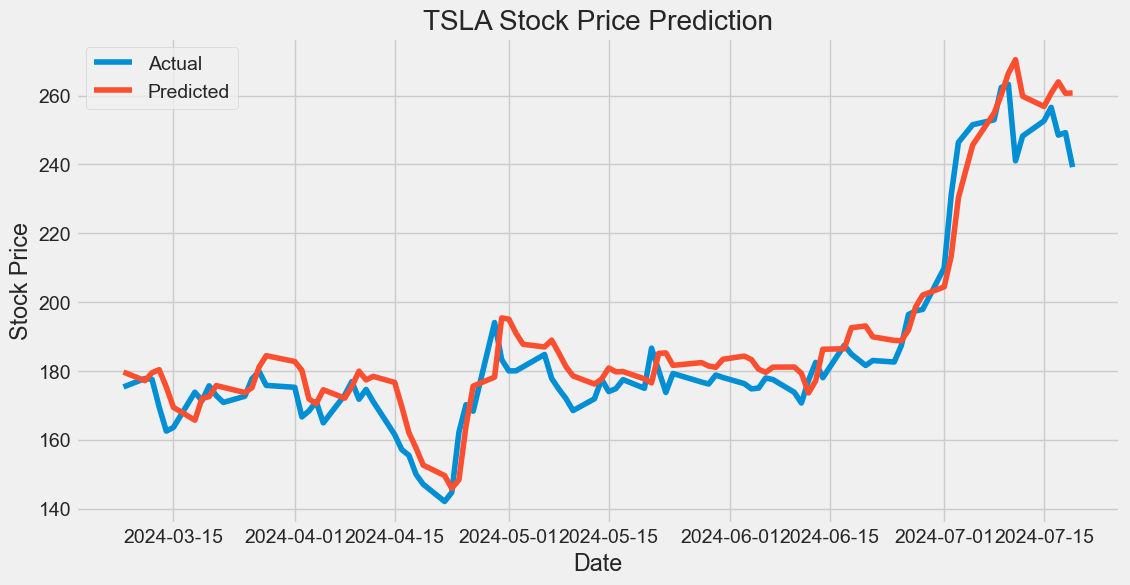

3/3 [==============================] - 1s 9ms/step
Evaluation results for AMD:
MAE = 8.583524709546577, RMSE = 9.698203894245635


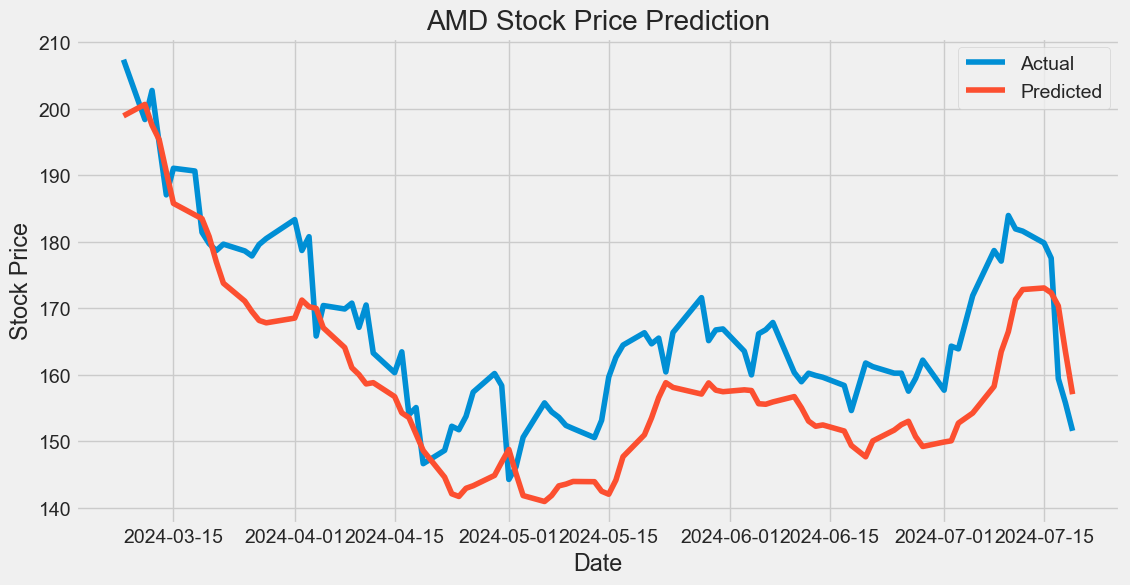

3/3 [==============================] - 1s 7ms/step
Evaluation results for NVDA:
MAE = 8.420592393040906, RMSE = 10.137323744572454


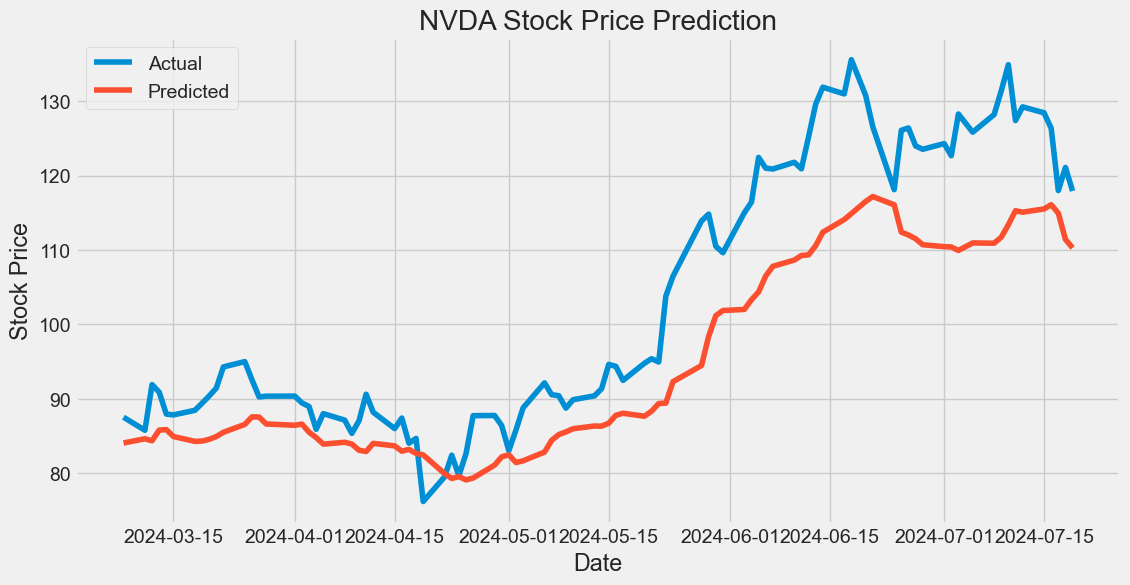

In [43]:
# Function to evaluate the model
def evaluate_models(model, X_test, y_test, scaler):
    y_pred = model.predict(X_test)

    # Inverse transform the predictions
    y_pred_inv = scaler.inverse_transform(np.concatenate((X_test[:, -1, :], y_pred), axis=1))[:, -1]
    original_ytest = scaler.inverse_transform(np.concatenate((X_test[:, -1, :], y_test.reshape(-1, 1)), axis=1))[:, -1]

    mae = mean_absolute_error(original_ytest, y_pred_inv)
    rmse = np.sqrt(mean_squared_error(original_ytest, y_pred_inv))
    return {'MAE': mae, 'RMSE': rmse}, y_pred_inv, original_ytest

# Function to plot y_pred vs y_test
def plot_predictions(dates, y_test, y_pred, stock_name):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_test, label='Actual')
    plt.plot(dates, y_pred, label='Predicted')
    plt.title(f'{stock_name} Stock Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

evaluation_results = {}
for stock in tech_list:
    X_train, X_test, y_train, y_test, dates_test_seq = processed_data[stock]
    results, y_pred_inv, original_ytest = evaluate_models(trained_models[stock], X_test, y_test, scalers[stock])
    evaluation_results[stock] = results
    
    print(f"Evaluation results for {stock}:")
    print(f"MAE = {results['MAE']}, RMSE = {results['RMSE']}")
    
    # Plot predictions
    plot_predictions(dates_test_seq, original_ytest, y_pred_inv, stock)

In [45]:
import keras_tuner as kt

# Define a function to create the model with hyperparameters
def build_model(hp, input_shape):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units1', min_value=32, max_value=512, step=32),
                   return_sequences=True, input_shape=input_shape))
    model.add(Dropout(hp.Float('dropout1', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units2', min_value=32, max_value=512, step=32), return_sequences=False))
    model.add(Dropout(hp.Float('dropout2', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Apply the process only to the first stock in tech_list
first_stock = tech_list[0]
X_train, X_test, y_train, y_test, dates_test_seq = processed_data[first_stock]

# Set the input_shape variable
input_shape = (X_train.shape[1], X_train.shape[2])
  
# Create a tuner object with a lambda function to pass input_shape
tuner = kt.RandomSearch(
    lambda hp: build_model(hp, input_shape),
    objective='val_loss',
    max_trials=5,  # Limit the number of trials to 5
    executions_per_trial=1,
    directory='my_dir',
    project_name=f'stock_price_prediction_{stock}'
)
    
X_train_tune = X_train[:int(len(X_train) * 0.9)]
y_train_tune = y_train[:int(len(y_train) * 0.9)]
X_val_tune = X_train[int(len(X_train) * 0.9):]
y_val_tune = y_train[int(len(y_train) * 0.9):]

tuner.search(X_train_tune, y_train_tune, epochs=100, validation_data=(X_val_tune, y_val_tune), verbose=1)
 
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    
print(f"Optimal hyperparameters for {stock}:")
print(f"units1: {best_hps.get('units1')}")
print(f"dropout1: {best_hps.get('dropout1')}")
print(f"units2: {best_hps.get('units2')}")
print(f"dropout2: {best_hps.get('dropout2')}")

Trial 5 Complete [00h 20m 41s]
val_loss: 0.0003068597870878875

Best val_loss So Far: 0.00028865167405456305
Total elapsed time: 00h 57m 46s
Optimal hyperparameters for NVDA:
units1: 160
dropout1: 0.0
units2: 256
dropout2: 0.4


In [53]:
# Define the LSTM model
def best_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=160, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0))
    model.add(LSTM(units=256, return_sequences=False))
    model.add(Dropout(0.4))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.summary()
    return model

#Train LSTM models for each stock and store them in a dictionary
best_trained_models = {}
for stock in tech_list:
    X_train, X_test, y_train, y_test, _ = processed_data[stock]
    bmodel = best_model((X_train.shape[1], X_train.shape[2]))
    bmodel.fit(X_train, y_train, epochs=250, batch_size=64, verbose=0)
    best_trained_models[stock] = bmodel

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 30, 160)           110720    
                                                                 
 dropout_8 (Dropout)         (None, 30, 160)           0         
                                                                 
 lstm_9 (LSTM)               (None, 256)               427008    
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 537985 (2.05 MB)
Trainable params: 537985 (2.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential

3/3 [==============================] - 0s 31ms/step
Hypertuned Evaluation results for TSLA:
MAE = 4.963618891839849, RMSE = 7.159550316857211


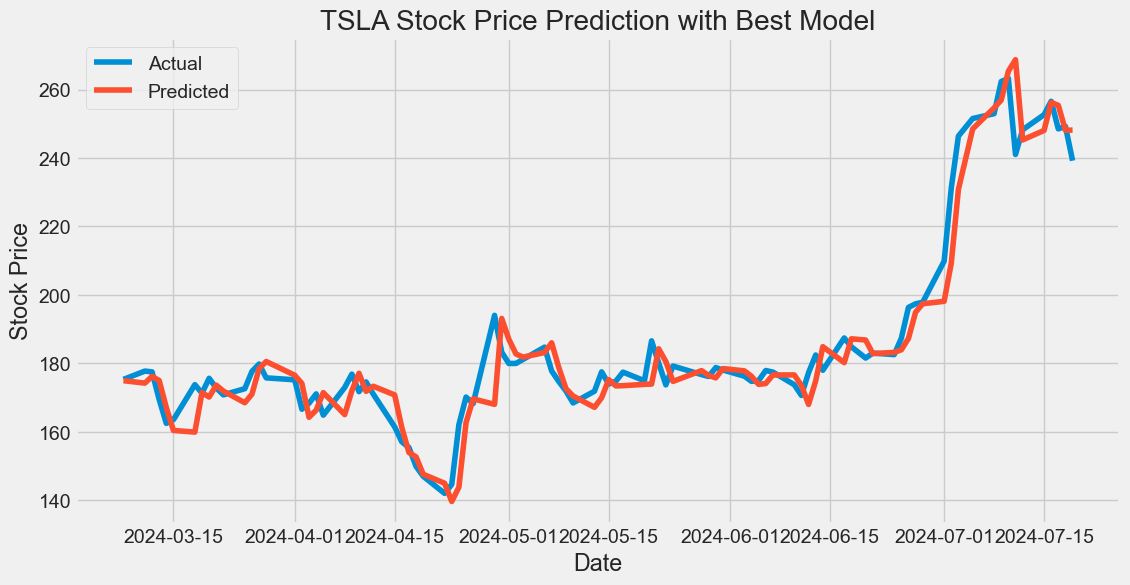

3/3 [==============================] - 0s 21ms/step
Hypertuned Evaluation results for AMD:
MAE = 3.65240046665591, RMSE = 4.907449024019578


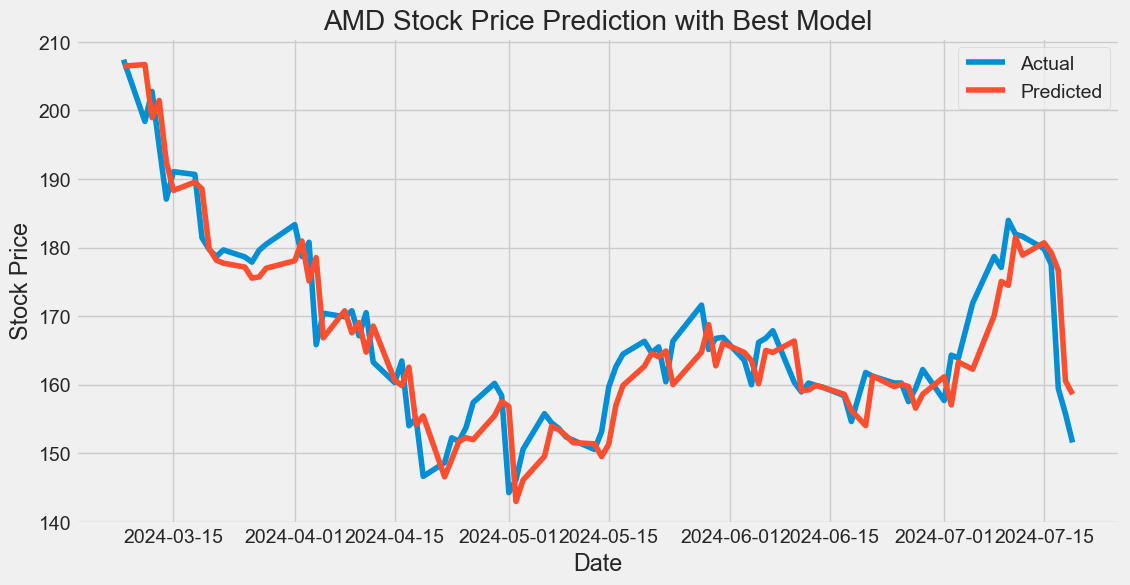

3/3 [==============================] - 0s 20ms/step
Hypertuned Evaluation results for NVDA:
MAE = 10.742141554010868, RMSE = 12.787243059631917


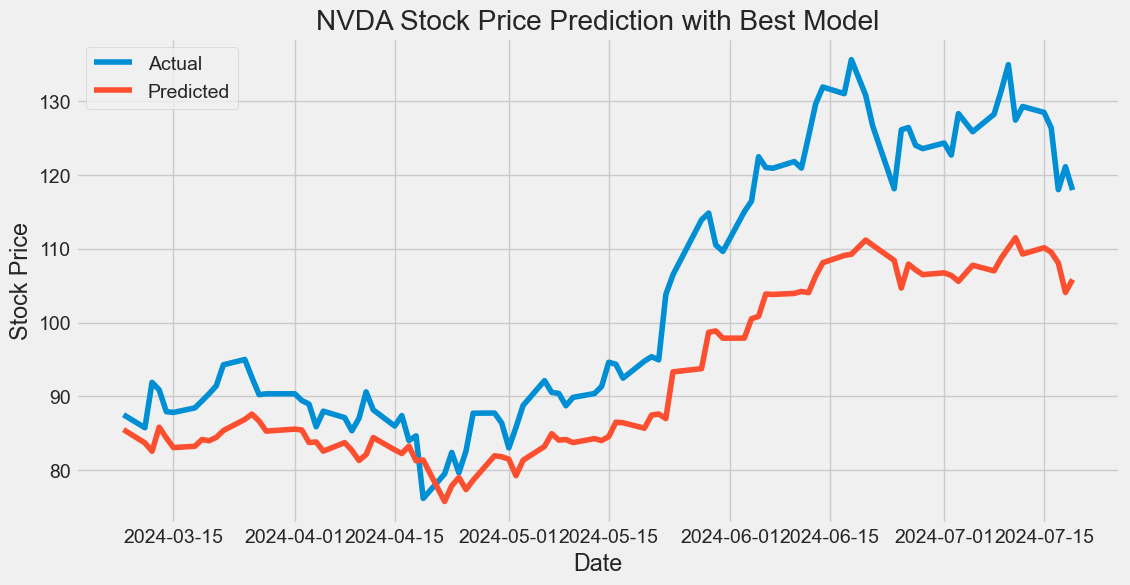

In [85]:
# Function to evaluate the model
def evaluate_models(model, X_test, y_test, scaler):
    y_pred = model.predict(X_test)

    # Inverse transform the predictions
    y_pred_inv = scaler.inverse_transform(np.concatenate((X_test[:, -1, :], y_pred), axis=1))[:, -1]
    original_ytest = scaler.inverse_transform(np.concatenate((X_test[:, -1, :], y_test.reshape(-1, 1)), axis=1))[:, -1]

    mae = mean_absolute_error(original_ytest, y_pred_inv)
    rmse = np.sqrt(mean_squared_error(original_ytest, y_pred_inv))
    return {'MAE': mae, 'RMSE': rmse}, y_pred_inv, original_ytest

# Function to plot y_pred vs y_test
def plot_predictions(dates, y_test, y_pred, stock_name):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_test, label='Actual')
    plt.plot(dates, y_pred, label='Predicted')
    plt.title(f'{stock_name} Stock Price Prediction with Best Model')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

evaluation_results = {}
for stock in tech_list:
    X_train, X_test, y_train, y_test, dates_test_seq = processed_data[stock]
    results, y_pred_inv, original_ytest = evaluate_models(best_trained_models[stock], X_test, y_test, scalers[stock])
    evaluation_results[stock] = results
    
    print(f"Hypertuned Evaluation results for {stock}:")
    print(f"MAE = {results['MAE']}, RMSE = {results['RMSE']}")
    
    # Plot predictions
    plot_predictions(dates_test_seq, original_ytest, y_pred_inv, stock)

3/3 [==============================] - 0s 23ms/step
Hypertuned Evaluation results for TSLA:
MAE = 4.963618891839849, RMSE = 7.159550316857211


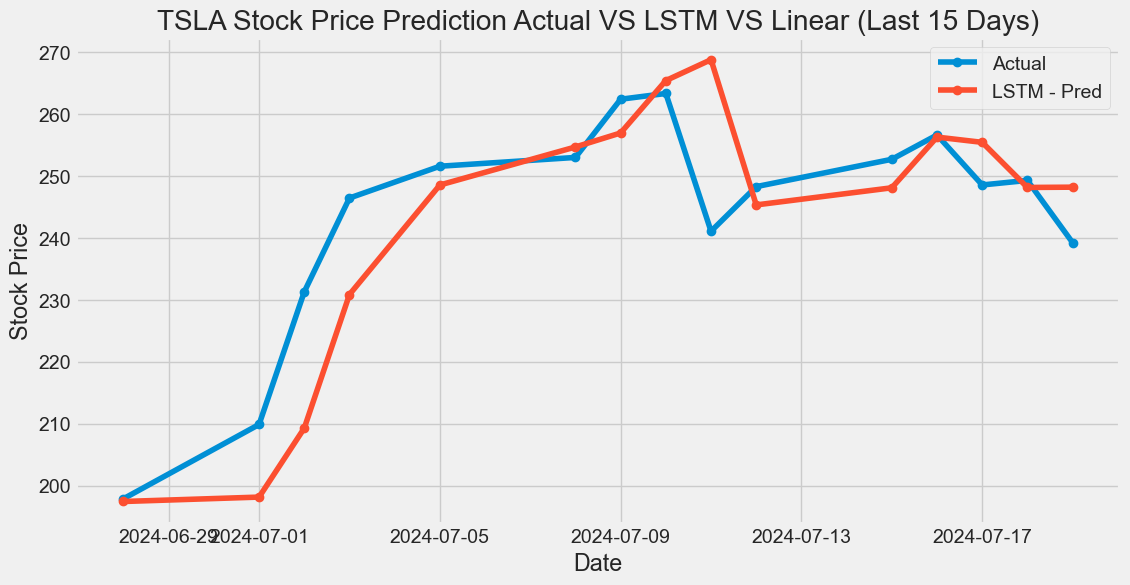

3/3 [==============================] - 0s 23ms/step
Hypertuned Evaluation results for AMD:
MAE = 3.65240046665591, RMSE = 4.907449024019578


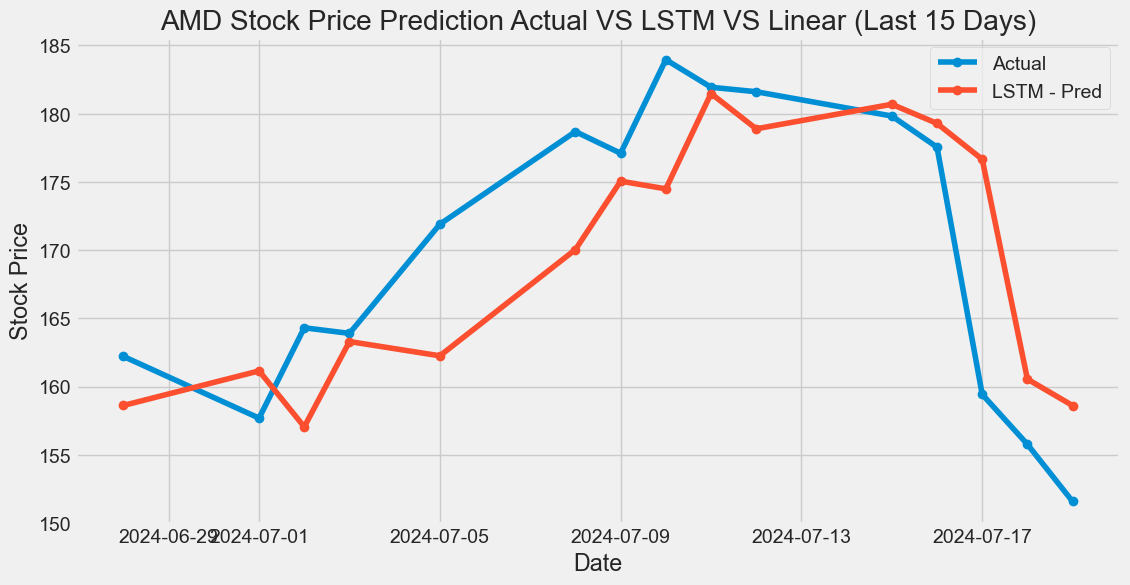

3/3 [==============================] - 0s 22ms/step
Hypertuned Evaluation results for NVDA:
MAE = 10.742141554010868, RMSE = 12.787243059631917


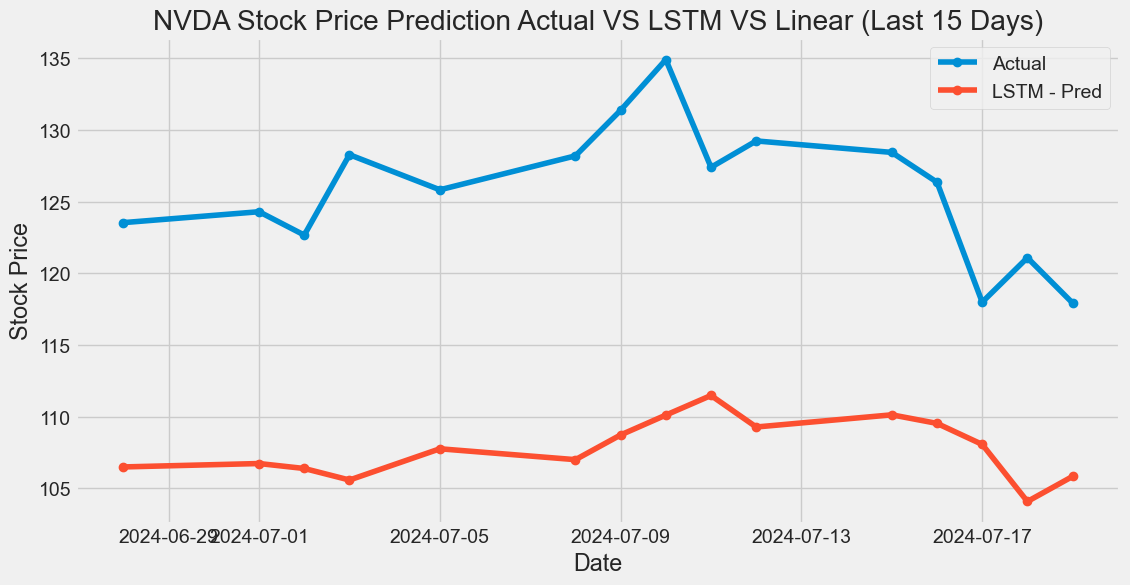

In [87]:
def plot_comparison(dates, y_test, y_pred, stock_name):
    plt.figure(figsize=(12, 6))
    plt.plot(dates[-15:], y_test[-15:], 'o-', label='Actual')
    plt.plot(dates[-15:], y_pred[-15:], 'o-', label='LSTM - Pred')
    plt.title(f'{stock_name} Stock Price Prediction Actual VS LSTM VS Linear (Last 15 Days)')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

evaluation_results = {}
for stock in tech_list:
    X_train, X_test, y_train, y_test, dates_test_seq = processed_data[stock]
    results, y_pred_inv, original_ytest = evaluate_models(best_trained_models[stock], X_test, y_test, scalers[stock])
    evaluation_results[stock] = results
    
    print(f"Hypertuned Evaluation results for {stock}:")
    print(f"MAE = {results['MAE']}, RMSE = {results['RMSE']}")
    
    # Plot predictions for the last 15 days
    plot_comparison(dates_test_seq, original_ytest, y_pred_inv, stock)

3/3 [==============================] - 0s 27ms/step
Hypertuned Evaluation results for TSLA:
LSTM - MAE = 4.963618891839849, RMSE = 7.159550316857211
Linear Regression: MAE = 4.761281658580042, RMSE = 6.569041060293892


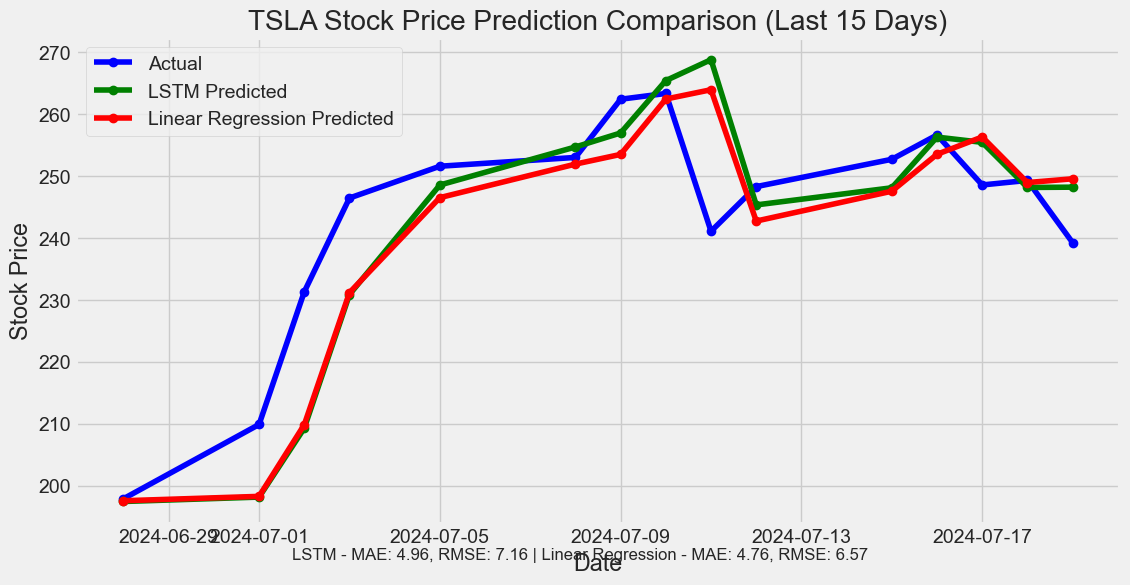

3/3 [==============================] - 0s 23ms/step
Hypertuned Evaluation results for AMD:
LSTM - MAE = 3.65240046665591, RMSE = 4.907449024019578
Linear Regression: MAE = 3.7955258079826337, RMSE = 5.225885299599488


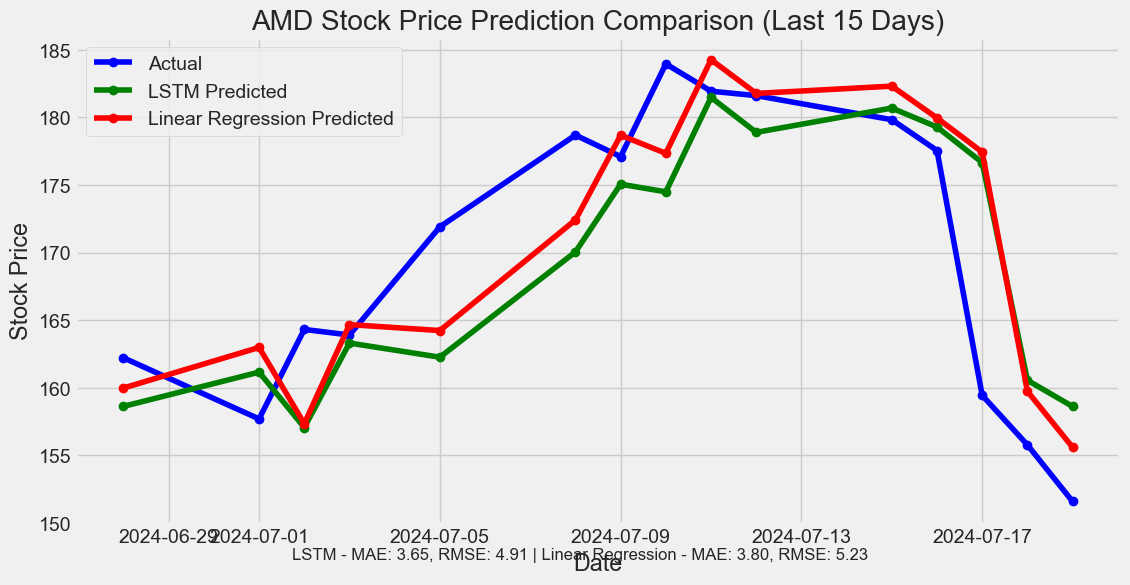

3/3 [==============================] - 0s 23ms/step
Hypertuned Evaluation results for NVDA:
LSTM - MAE = 10.742141554010868, RMSE = 12.787243059631917
Linear Regression: MAE = 2.420699357476408, RMSE = 3.2430916311819407


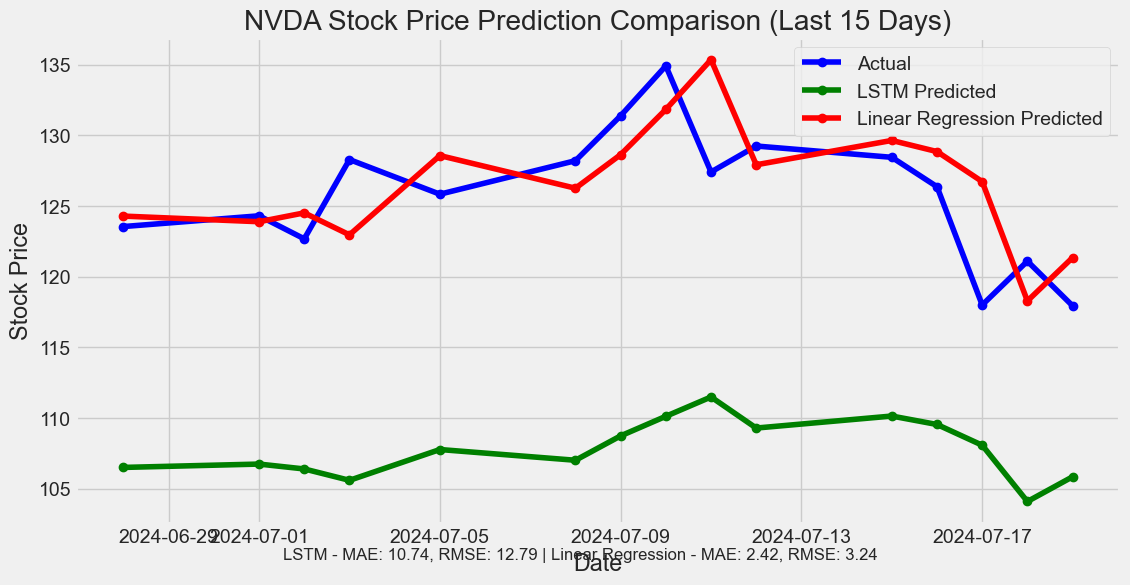

In [111]:
def plot_comparison(dates, actual, lstm_pred, linear_pred, stock_name, lstm_metrics, linear_metrics):
    plt.figure(figsize=(12, 6))
    
    # Plot actual prices
    plt.plot(dates[-15:], actual[-15:], 'o-', label='Actual', color='blue')
    
    # Plot LSTM predicted prices
    plt.plot(dates[-15:], lstm_pred[-15:], 'o-', label='LSTM Predicted', color='green')
    
    # Plot Linear Regression predicted prices
    plt.plot(dates[-15:], linear_pred[-15:], 'o-', label='Linear Regression Predicted', color='red')
    
    plt.title(f'{stock_name} Stock Price Prediction Comparison (Last 15 Days)')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    
    # Display MAE and RMSE for both models
    plt.figtext(0.5, 0.01, f"LSTM - MAE: {lstm_metrics['MAE']:.2f}, RMSE: {lstm_metrics['RMSE']:.2f} | "
                           f"Linear Regression - MAE: {linear_metrics['MAE']:.2f}, RMSE: {linear_metrics['RMSE']:.2f}",
                ha="center", fontsize=12)
    
    plt.show()

# Evaluate the models
def ml_evaluate_models(models, X_test, y_test):
    results = {}
    for model_name, model in models.items():
        predictions = model.predict(X_test)
        mae = mean_absolute_error(y_test, predictions)
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        results[model_name] = {'MAE': mae, 'RMSE': rmse}
    return results

# Evaluate the LSTM and Linear Regression models
evaluation_results = {}
ml_evaluation_results = {}
for stock in tech_list:
    X_train, X_test, y_train, y_test, dates_test_seq = processed_data[stock]
    lstm_results, lstm_pred_inv, original_ytest = evaluate_models(best_trained_models[stock], X_test, y_test, scalers[stock])
    evaluation_results[stock] = lstm_results
    
    X_train_ml, X_test_ml, y_train_ml, y_test_ml = ml_processed_data[stock]
    ml_evaluation_results[stock] = ml_evaluate_models(ml_trained_models[stock], X_test_ml, y_test_ml)
    
    print(f"Hypertuned Evaluation results for {stock}:")
    print(f"LSTM - MAE = {lstm_results['MAE']}, RMSE = {lstm_results['RMSE']}")
    
    for model_name, metrics in ml_evaluation_results[stock].items():
        if model_name == 'Linear Regression':
            linear_metrics = metrics
            print(f"{model_name}: MAE = {metrics['MAE']}, RMSE = {metrics['RMSE']}")
    
    # Get Linear Regression predictions and metrics
    ml_best_model = ml_trained_models[stock]['Linear Regression']
    linear_predictions = ml_best_model.predict(X_test_ml)
    
    linear_metrics = ml_evaluation_results[stock]['Linear Regression']
    
    # Plot predictions for the last 15 days
    plot_predictions(dates_test_seq, original_ytest, lstm_pred_inv, linear_predictions, stock, lstm_results, linear_metrics)
